# Initializatoin

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# cd /content/drive/MyDrive/Colab\ Notebooks/Deep\ Learning\ Course/HW03
# i have copied and pasted the code here instead of mounting the drive

In [3]:
import subprocess
import unicodedata
import string
import torch
import random
from io import open
import glob
import os

class Dataset:
    def __init__(self):
        if not (os.path.exists("data.zip") and os.path.exists("data")):
            # Run wget command
            wget_process = subprocess.Popen(['wget', 'https://download.pytorch.org/tutorial/data.zip'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            wget_output, wget_error = wget_process.communicate()

            # Check for wget errors
            if wget_error:
                print("Error occurred while downloading data.zip:", wget_error.decode())
            else:
                print("Downloaded data.zip successfully.")

            # Run unzip command
            unzip_process = subprocess.Popen(['unzip', 'data.zip'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            unzip_output, unzip_error = unzip_process.communicate()

            # Check for unzip errors
            if unzip_error:
                print("Error occurred while unzipping data.zip:", unzip_error.decode())
            else:
                print("Unzipped data.zip successfully.")
        else:
            print("Files already exist, skipping download and extraction.")

        def findFiles(path):
            return glob.glob(path)

        all_letters = string.ascii_letters + " .,;'"
        n_letters = len(all_letters)

        # Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
        def unicodeToAscii(s):
            return ''.join(
                c for c in unicodedata.normalize('NFD', s)
                if unicodedata.category(c) != 'Mn'
                and c in all_letters
            )


        # Build the category_lines dictionary, a list of names per language
        category_lines = {}
        all_categories = []

        # Read a file and split into lines
        def readLines(filename):
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            return [unicodeToAscii(line) for line in lines]

        for filename in findFiles('data/names/*.txt'):
            category = os.path.splitext(os.path.basename(filename))[0]
            all_categories.append(category)
            lines = readLines(filename)
            category_lines[category] = lines

        self.n_categories = len(all_categories)
        self.all_categories = all_categories
        self.category_lines = category_lines
        self.n_letters = n_letters
        self.all_letters = all_letters

    def letterToIndex(self, letter):
        return self.all_letters.find(letter)

    # Just for demonstration, turn a letter into a <1 x n_letters> Tensor
    def letterToTensor(self, letter):
        tensor = torch.zeros(1, self.n_letters)
        tensor[0][self.letterToIndex(letter)] = 1
        return tensor

    # Turn a line into a <line_length x 1 x n_letters>,
    # or an array of one-hot letter vectors
    def lineToTensor(self, line):
        tensor = torch.zeros(len(line), 1, self.n_letters)
        for li, letter in enumerate(line):
            tensor[li][0][self.letterToIndex(letter)] = 1
        return tensor

    def categoryFromOutput(self, output):
        top_n, top_i = output.topk(1)
        category_i = top_i[0].item()
        return self.all_categories[category_i], category_i

    def randomChoice(self, l):
        return l[random.randint(0, len(l) - 1)]

    def randomTrainingExample(self, ):
        category = self.randomChoice(self.all_categories)
        line = self.randomChoice(self.category_lines[category])
        category_tensor = torch.tensor([self.all_categories.index(category)], dtype=torch.long)
        line_tensor = self.lineToTensor(line)
        return category, line, category_tensor, line_tensor

## Imports

In [4]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.nn import Parameter

# from name_dataset import Dataset # i have copied and pasted the code here

# RNN

## Traditional RNN

In the introductory section, we delve into the architecture of Recurrent Neural Networks (RNNs) and elucidate their training methodologies. To gain a deeper understanding of RNNs, you're encouraged to explore further [HERE](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-network)

For the task at hand, you've been furnished with the Names dataset, a compilation comprising thousands of surnames from 18 distinct languages of origin. Your objective is to prognosticate the language of origin for a given name, relying solely on its orthography. Your task primarily involves implementing the section demarcated by `#your_code`.

In [5]:
dataset = Dataset()
for i in range(10):
    category, line, _, _ = dataset.randomTrainingExample()
    print('category =', category, '- random name =', line)

Files already exist, skipping download and extraction.
category = German - random name = Leitner
category = Polish - random name = Zdunowski
category = Spanish - random name = Escarcega
category = Russian - random name = Djunkovsky
category = Czech - random name = Sokolik
category = German - random name = Krebs
category = Portuguese - random name = Ferreira
category = Italian - random name = Ventura
category = Portuguese - random name = Palmeiro
category = Spanish - random name = Vives


In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        #your_code
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):

        #your_code
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.i2h(combined))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = dataset.n_letters
n_categories = dataset.n_categories
rnn = RNN(n_letters, n_hidden, n_categories)

In [7]:
#your_code
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, name_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    #your_code
    for i in range(name_tensor.size()[0]):
      output, hidden = rnn(name_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

And here you can train your model and see it's performance after each 5000 iterations

5000 5% 2.6686 Jon is predicted as a "Scottish" name, status = ✗ (Korean)
10000 10% 2.8007 Issa is predicted as a "Japanese" name, status = ✗ (Arabic)
15000 15% 4.2156 Albuquerque is predicted as a "French" name, status = ✗ (Portuguese)
20000 20% 4.5316 Virvitsiotti is predicted as a "Polish" name, status = ✗ (Russian)
25000 25% 0.6176 Jon is predicted as a "Korean" name, status = ✓
30000 30% 0.9569 Di pietro is predicted as a "Italian" name, status = ✓
35000 35% 1.5350 Schrader is predicted as a "Dutch" name, status = ✗ (German)
40000 40% 0.4779 Bustillo is predicted as a "Spanish" name, status = ✓
45000 45% 1.4478 Lavigne is predicted as a "Italian" name, status = ✗ (French)
50000 50% 2.7421 Mclaren is predicted as a "Dutch" name, status = ✗ (English)
55000 55% 1.2500 Lewerenz is predicted as a "Spanish" name, status = ✗ (German)
60000 60% 2.3908 Lakin is predicted as a "Russian" name, status = ✗ (English)
65000 65% 1.5277 Waring is predicted as a "German" name, status = ✗ (English)


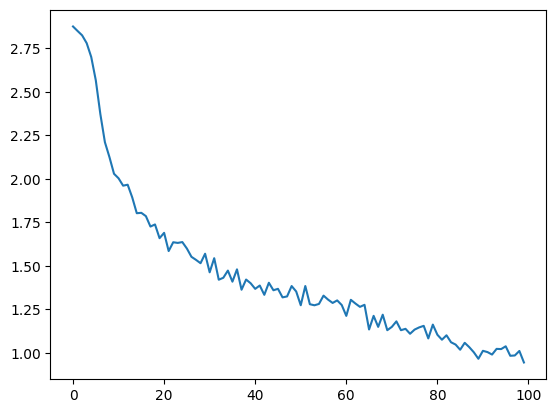

In [8]:
n_iters = 100000
print_every = 5000

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = dataset.randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, _ = dataset.categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s is predicted as a "%s" name, status = %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    if iter % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

## Traditional RNN Disadvantages

In this part, we aim to delve into the limitations of traditional RNNs:
1.   Recurrent computation is slow
2.   They have difficulty accessing information from many steps back.

You are provided with a simple code that helps you to give the idea better. By modifying this code, you are able to demonstrate the mentioned disadvantages, but you are also free to change the code if needed or use any dataset you want.

**Question:** Do you think using GPU instead of CPU completely solves the first problem?



Note: The main goal of this part is to help you understand these problems better. Don't be too hard to implement and delivery.

<font color='red'> <div dir="ltl">
Answer: No, because RNN doesn't allow parallel computation comparing to transformers.
Please note that GPU helps us to get the best performance of GPU but it's not enough because it is sequential and we need the previous steps for the next steps.

Epoch [10/400], Loss: 1.2788
Epoch [20/400], Loss: 1.1712
Epoch [30/400], Loss: 1.0684
Epoch [40/400], Loss: 0.9651
Epoch [50/400], Loss: 0.8550
Epoch [60/400], Loss: 0.7357
Epoch [70/400], Loss: 0.6094
Epoch [80/400], Loss: 0.4827
Epoch [90/400], Loss: 0.3651
Epoch [100/400], Loss: 0.2651
Epoch [110/400], Loss: 0.1888
Epoch [120/400], Loss: 0.1380
Epoch [130/400], Loss: 0.1089
Epoch [140/400], Loss: 0.0945
Epoch [150/400], Loss: 0.0873
Epoch [160/400], Loss: 0.0826
Epoch [170/400], Loss: 0.0781
Epoch [180/400], Loss: 0.0736
Epoch [190/400], Loss: 0.0691
Epoch [200/400], Loss: 0.0649
Epoch [210/400], Loss: 0.0609
Epoch [220/400], Loss: 0.0570
Epoch [230/400], Loss: 0.0532
Epoch [240/400], Loss: 0.0495
Epoch [250/400], Loss: 0.0459
Epoch [260/400], Loss: 0.0424
Epoch [270/400], Loss: 0.0391
Epoch [280/400], Loss: 0.0358
Epoch [290/400], Loss: 0.0327
Epoch [300/400], Loss: 0.0297
Epoch [310/400], Loss: 0.0267
Epoch [320/400], Loss: 0.0238
Epoch [330/400], Loss: 0.0210
Epoch [340/400], Lo

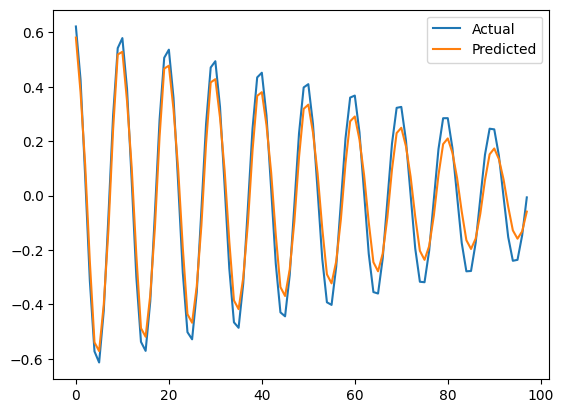

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate sinusoidal temperature data with decreasing range over time
np.random.seed(0)
num_periods = 50
timesteps_per_period = 10
total_timesteps = num_periods * timesteps_per_period

# Generate decreasing factor
decreasing_factor = np.linspace(1, 0.1, total_timesteps)

# Generate temperature data with decreasing sinusoidal range
temperature_data = np.sin(np.linspace(0, 2*np.pi*num_periods, total_timesteps)) * decreasing_factor

# Normalize the data
temperature_data = (temperature_data - np.mean(temperature_data)) / np.std(temperature_data)

# Convert numpy array to PyTorch tensor
temperature_data = torch.tensor(temperature_data, dtype=torch.float32).view(-1, 1)

# Define function to create dataset with sinusoidal pattern
def create_dataset(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        seq_in = data[i:i+seq_length]
        seq_out = data[i+seq_length]
        X.append(seq_in)
        Y.append(seq_out)
    return torch.stack(X), torch.stack(Y)

# Define sequence length and create dataset
sequence_length = 10  # Number of previous days to look at for prediction
X, Y = create_dataset(temperature_data, sequence_length)

# Split the dataset into train and test sets
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = 1
hidden_size = 10
output_size = 1

# Instantiate the model
model = SimpleRNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# Plot actual vs predicted
plt.plot(Y_test.numpy(), label='Actual')
plt.plot(test_predictions.numpy(), label='Predicted')
plt.legend()
plt.show()

# LSTM Preparation

Now that you have experience with traditional RNNs, it's time to implement the LSTM model. Your goal is to implement the cell and model for LSTM architecture. The proposed dataset for this section is MNIST, allowing you to focus solely on model implementation.

In [10]:
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.ToTensor())

batch_size = 128
n_iters = 6000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## LSTM Cells

In [12]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        hx, cx = hx

        gates = self.xh(input) + self.hh(hx)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)


        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        g_t = torch.tanh(cell_gate)
        o_t = torch.sigmoid(output_gate)

        cy = f_t * cx + i_t * g_t
        hy = o_t * torch.tanh(cy)

        return (hy, cy)

## LSTM Models

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)



    def forward(self, x):

        h0 = torch.zeros(x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(x.size(0), self.hidden_dim).to(x.device)

        hn, cn = h0, c0
        outs = []

        for seq in range(x.size(1)):
            # your code
            hn, cn = self.lstm(x[:, seq, :], (hn, cn))
            outs.append(hn)

        #your code
        out = self.fc(outs[-1].squeeze())
        return out

In [14]:
input_dim = 28
hidden_dim = 128
layer_dim = 1  # ONLY 1 OR 2
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

# your code
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# your code

num_epochs = 3
iter_count = 0
for epoch in range(num_epochs):
    # print(f'Epoch {epoch + 1} started')
    running_loss = 0.0
    total_samples = 0
    correct_samples = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28, 28)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # iter_count += 1

        running_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_samples += (predicted == labels).sum().item()

    # print('Epoch: {}. Loss: {}. Accuracy: {}%'.format(epoch + 1, loss.item()))
    epoch_loss = running_loss / total_samples
    epoch_accuracy = 100 * correct_samples / total_samples
    print(f'Epoch: {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


Epoch: 1, Loss: 0.6548, Accuracy: 78.34%
Epoch: 2, Loss: 0.1704, Accuracy: 94.98%
Epoch: 3, Loss: 0.1171, Accuracy: 96.47%


# Sentiment Analysis

Now you are ready to face a real-world problem. In this task, we want you to do a sentiment analysis on the [IMDB dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). The main goal is to reach more than an acceptable accuracy of **75%** on LSTM model. You are free to use torch.nn.LSTM to design your architecture, but you must prepare the IMDB dataset on your own.

In [ ]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] =  "/content"
# in the previous line, i assumed that i am running in google colab

!chmod 600 /content/kaggle.json

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [ ]:
!unzip imdb-dataset-of-50k-movie-reviews.zip

In [ ]:
data = pd.read_csv('IMDB Dataset.csv')

In [ ]:
print(data.shape)
data.head()

In [ ]:
set(data['sentiment'])

In [23]:
# split into test/train/val
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(32000, 2)
(8000, 2)
(10000, 2)


In [ ]:
# preprocessing
tokenizer = get_tokenizer('basic_english')

train_data['review'] = train_data['review'].apply(lambda x: tokenizer(x.lower()))
val_data['review'] = val_data['review'].apply(lambda x: tokenizer(x.lower()))
test_data['review'] = test_data['review'].apply(lambda x: tokenizer(x.lower()))

token_counts = Counter()
for tokens in train_data['review']:
    token_counts.update(tokens)

vocab = build_vocab_from_iterator(map(lambda tokens: tokens, train_data['review']), specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
print(len(vocab))

In [ ]:
# define datasets

class IMDBDataset(Dataset):
    def __init__(self, data, vocab, max_len=500):
        self.data = data
        self.vocab = vocab
        self.max_len = max_len
        self.label_mapping = {'negative': 0, 'positive': 1}


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        review = self.data.iloc[idx]['review']
        sentiment = self.data.iloc[idx]['sentiment']
        sentiment_int = self.label_mapping[sentiment]
        tokens = [self.vocab[token] for token in review[:self.max_len]]
        # tokens = tokens + [self.vocab['<pad>']] * (self.max_len - len(tokens))
        tokens = tokens + [self.vocab['<PAD>']] * (self.max_len - len(tokens))
        tensor = torch.tensor(tokens, dtype=torch.long)
        # print(tensor)
        # print(sentiment)
        return tensor, sentiment_int

train_dataset = IMDBDataset(train_data, vocab)
val_dataset = IMDBDataset(val_data, vocab)
test_dataset = IMDBDataset(test_data, vocab)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
# define model
class IMDB_Model(nn.Module):
    def __init__(self, output_size, hidden_len, embedding_size, n_layers):
        super(IMDB_Model, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_len, output_size)
        self.Sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.Sigmoid(x)

        return x

In [37]:
# parameters definition
output_size = 1
embedding_size = 128
hidden_size = 256
n_layers = 2

model = IMDB_Model(output_size, hidden_size, embedding_size, n_layers)
print(model)

# Define the loss function and optimizer
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

IMDB_Model(
  (embedding): Embedding(115986, 128)
  (lstm): LSTM(128, 256, num_layers=2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)


IMDB_Model(
  (embedding): Embedding(115986, 128)
  (lstm): LSTM(128, 256, num_layers=2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)

In [38]:
for epoch in range(num_epochs):
    running_loss = 0.0
    total_samples = 0
    correct_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        # outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        predicted = torch.tensor([1 if i == True else 0 for i in outputs > 0.5], device=device)
        equals = predicted == labels
        acc = torch.mean(equals.type(torch.FloatTensor))
        correct_samples += acc.item()

        running_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
        # predicted = (outputs > 0).long()
        # correct_samples += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = 100 * correct_samples / total_samples
    print(f'Epoch: {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


Epoch: 1, Loss: 0.6933, Accuracy: 0.79%
Epoch: 2, Loss: 0.6924, Accuracy: 0.80%
Epoch: 3, Loss: 0.6897, Accuracy: 0.81%


In [39]:
# test
model.eval()
total_samples = 0
correct_samples = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze(1)

        total_samples += labels.size(0)
        predicted = torch.tensor([1 if i == True else 0 for i in outputs > 0.5], device=device)
        equals = predicted == labels
        acc = torch.mean(equals.type(torch.FloatTensor))
        correct_samples += acc.item()

val_accuracy = 100 * correct_samples / total_samples
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Validation Accuracy: 0.78%


The accuracy is more than 75% as we wanted.